---
title: Spectral Clustering
date: 2021-04-30 18:00:00 -0700
math: true
categories: [PIC16B-blog]
tags: [matplotlib, linear-algebra, data-analysis]
---
In this blog post, we will study and create a [spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering) algorithm which is basically used in exploratory data analysis to divide data points into different group where each group has their own characteristics/features. 

### Notation

In all the math below: 

- Boldface capital letters like $\mathbf{A}$ refer to matrices (2d arrays of numbers). 
- Boldface lowercase letters like $\mathbf{v}$ refer to vectors (1d arrays of numbers). 
- $\mathbf{A}\mathbf{B}$ refers to a matrix-matrix product (`A@B`). $\mathbf{A}\mathbf{v}$ refers to a matrix-vector product (`A@v`). 

## Introduction

*Spectral clustering* allows us to extract meaningful information from data sets with complex structures. It's one of the most widely used techniques in data exploratory process. Before delving into this, one may ask what kind of data sets that need to be analyzed using spectral clustering. Before addressing that question, let's take a look at some examples where we actually do not need the help from spectral clustering algorithm.

In [1]:
# import needed libraries
import numpy as np
from sklearn import datasets
from matplotlib import pyplot as plt

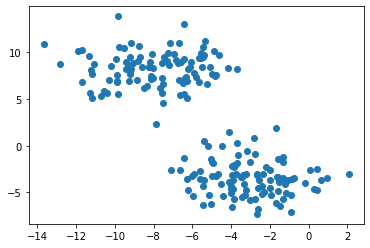

In [2]:
# number of data points
n = 200

np.random.seed(1111)
# make two "blobs" of data points
X, y = datasets.make_blobs(n_samples=n, shuffle=True, random_state=None, centers = 2, cluster_std = 2.0)
# plot 
plt.scatter(X[:,0], X[:,1])

Here we observe that the data is divided into two distinct regions ,i.e. two different blobs. In essence, *clustering* refers to the task of separating this data set into the two natural "blobs." K-means is a very common way to achieve this task, which has good performance on circular-ish blobs like these.

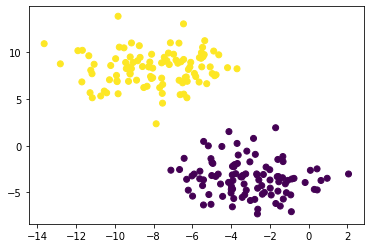

In [3]:
from sklearn.cluster import KMeans

# specify two clusters
km = KMeans(n_clusters = 2)
km.fit(X)

# plot with color indication for each cluster
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

That looks good. Now, let's explore something a bit more "erratic". Observe the following data set in which when plotted has a crescent shape.

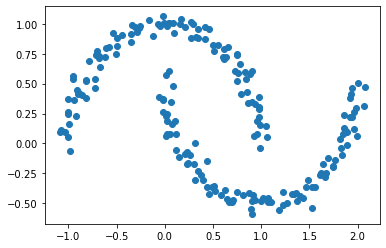

In [4]:
np.random.seed(1234)
n = 200
# generate a data sets with "crescent moon" shape
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)
# plot
plt.scatter(X[:,0], X[:,1])

We can still make out two meaningful clusters in the data, but now they aren't blobs but crescents. As before, the Euclidean coordinates of the data points are contained in the matrix `X`, while the labels of each point are contained in `y`. Now k-means won't work so well, because k-means is, by design, looking for circular clusters. 

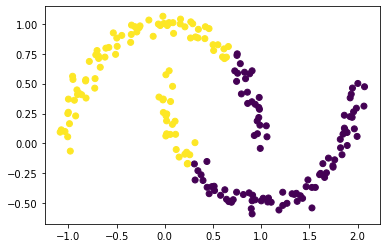

In [5]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Without a doubt, we can observe that the division is completely wrong, and k-means is definitely not the best algorithm for this task. So this is where spectral clustering comes to the rescue. In the following sections, we will create and implement the algorithm which would correctly identify the two crescents.

## Similarity Matrix

One of the first steps we need to perform is to create a *similarity matrix* $\mathbf{A}$ in which $\mathbf{A}_{ij}$ represents the measure of similarity between data points of indices $i$ and $j$. There are several ways to measure it, and for this post, we will be using $\epsilon$-neighborhood method. Specifically, when constructing the similarity matrix, if the distance between any two entry is within $\epsilon$ to each other, then we assign 1 to it with the exception that everything along the diagonal must be 0. For any pairwise distance that is not within the $\epsilon$-neighborhood, we assign 0 to those entries.

In [6]:
# a library to compute pairwise distance
from sklearn.metrics import pairwise_distances

epsilon = 0.4

# compute the pairwise distances 
A = pairwise_distances(X)
# any distance entry greater or equal to epsilon is set to 0
A[A >= epsilon] = 0
# any distance entry less than epsilon is set to 1
A[(A != 0) & (A < epsilon)] = 1
# fill the diagonal entries with 0
np.fill_diagonal(A, 0)
# let's take a look
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

## Normalized Cut

The matrix `A` now contains information about which points are near (within distance `epsilon`) which other points. We now pose the task of clustering the data points in `X` as the task of partitioning the rows and columns of `A`. 

Let $d_i = \sum_{j = 1}^n a_{ij}$ be the $i$th row-sum of $\mathbf{A}$, which is also called the *degree* of $i$. Let $C_0$ and $C_1$ be two clusters of the data points. We assume that every data point is in either $C_0$ or $C_1$. The cluster membership as being specified by `y`. We think of `y[i]` as being the label of point `i`. So, if `y[i] = 1`, then point `i` (and therefore row $i$ of $\mathbf{A}$) is an element of cluster $C_1$.  

The *binary norm cut objective* of a matrix $\mathbf{A}$ is the function 

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

In this expression, 
- $\mathbf{cut}(C_0, C_1) \equiv \sum_{i \in C_0, j \in C_1} a_{ij}$ is the *cut* of the clusters $C_0$ and $C_1$. 
- $\mathbf{vol}(C_0) \equiv \sum_{i \in C_0}d_i$, where $d_i = \sum_{j = 1}^n a_{ij}$ is the *degree* of row $i$ (the total number of all other rows related to row $i$ through $A$). The *volume* of cluster $C_0$ is a measure of the size of the cluster. 

A pair of clusters $C_0$ and $C_1$ is considered to be a "good" partition of the data when $N_{\mathbf{A}}(C_0, C_1)$ is small. To see why, let's look at each of the two factors in this objective function separately. 


### 1. The Cut Term

First, the cut term $\mathbf{cut}(C_0, C_1)$ is the number of nonzero entries in $\mathbf{A}$ that relate points in cluster $C_0$ to points in cluster $C_1$. A small cut indicates that there are significant amount of points in $C_0$ which are far away from points in $C_1$. Notice that this makes sense mathematically because of the way define we define our similarity matrix, i.e. any pairwise distance (entry) which is not within $epsilon$ distance is set to 0.

So, let's define a function to compute the cut term. From the mathematical expression of a cut, we can simply do so by summing up all $A_{ij}$ for each pair of points $(i,j)$ in different clusters, $C_0$ and $C_1$.

In [7]:
def cut(A, y):
    """
    Input 
    -----
    A(2d numpy array): similarity matrix
    y(1d numpy array): labels
    
    Output
    ------
    numerical value of the cut of the clusters C0 and C1
    """
    cut_sum = 0
    # loop through each row and column entry
    for i in range(n):
        for j in range(n):
            # make sure these are in different clusters
            if y[i] != y[j]:
                cut_sum += A[i, j]
    # counteract the effect of double counting
    return (cut_sum/2)

In order to see that the cut objective favors the true label over the random one, we will generate a random 1d numpy array filled with 0 and 1. Then, we will compare the cut term of each one.

In [8]:
rand = np.random.randint(2, size = n)
cut(A, y), cut(A, rand)

(13.0, 1116.0)

Indeed, the cut term of the true labels is considerably smaller than the cut of random label. This can be explained from the fact that the random label array imposes a different data structure on $A$ which statistically increases the probability of encountering different clusters within the array. This does lead the cut term of `rand` to be significantly larger than `y`.

### 2. The Volume Term 

Now take a look at the second factor in the norm cut objective. This is the *volume term*. As mentioned above, the *volume* of cluster $C_0$ is a measure of how "big" cluster $C_0$ is. If we choose cluster $C_0$ to be small, then $\mathbf{vol}(C_0)$ will be small and $\frac{1}{\mathbf{vol}(C_0)}$ will be large, leading to an undesirable higher objective value. 

Synthesizing, the binary normcut objective asks us to find clusters $C_0$ and $C_1$ such that:

1. There are relatively few entries of $\mathbf{A}$ that join $C_0$ and $C_1$. 
2. Neither $C_0$ and $C_1$ are too small. 

So, let's now write a function which computes that volumes of clusters $C_0$ and $C_1$.

In [9]:
def vols(A, y):
    """
    Input
    -----
    A(2d numpy array): similarity matrix
    y(1d numpy array): labels
    
    Output
    ------
    A tuple of volumes of C_0 and C_1
    """
    # gather all rows of cluster 0
    v0 = A[y == 0]
    # compute its sum
    v0_sum = np.sum(v0)
    # gather all rows with cluster 1
    v1 = A[y == 1]
    # compute its sum
    v1_sum = np.sum(v1)
    return (v0_sum, v1_sum)

Recall that the binary normalized cut objective of a similarity matrix $A$ with two clusters $C_0$ and $C_1$ is defined as

$$N_{\mathbf{A}}(C_0, C_1)\equiv \mathbf{cut}(C_0, C_1)\left(\frac{1}{\mathbf{vol}(C_0)} + \frac{1}{\mathbf{vol}(C_1)}\right)\;.$$

Let's then define a function called ``normcut()`` for the above expression.

In [10]:
def normcut(A, y):
    v0, v1 = vols(A, y)
    return cut(A,y)*(1/v0 + 1/v1)

Now, we compute and compare the normcut value of the true label `y` and the artificial label `rand` we generated above.

In [11]:
normcut(A, y), normcut(A, rand)

(0.011518412331615225, 0.995836336735081)

As we may deduce from the value of the cuts between two labels, it's intuitive here that the normcut of the true label is about 100x times smaller than the one which belongs to the random label.

## Orthogonal Objective Optimization

We have now defined a normalized cut objective which takes small values when the input clusters are joined by relatively few entries in $A$ and not too small. One approach to clustering is to try to find a cluster vector `y` such that `normcut(A,y)` is small. However, this is an NP-hard combinatorial optimization problem, which means that may not be possible to find the best clustering in practical time, even for relatively small data sets. We need a math trick! 

Here's the trick: define a new vector $\mathbf{z} \in \mathbb{R}^n$ such that: 

$$
z_i = 
\begin{cases}
    \frac{1}{\mathbf{vol}(C_0)} &\quad \text{if } y_i = 0 \\ 
    -\frac{1}{\mathbf{vol}(C_1)} &\quad \text{if } y_i = 1 \\ 
\end{cases}
$$


Note that the signs of  the elements of $\mathbf{z}$ contain all the information from $\mathbf{y}$: if $i$ is in cluster $C_0$, then $y_i = 0$ and $z_i > 0$. 

For any math major/enthusiasts, you're tasked with showing the following,

$$\mathbf{N}_{\mathbf{A}}(C_0, C_1) = 2\frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}}\;,$$

where $\mathbf{D}$ is the diagonal matrix with nonzero entries $d_{ii} = d_i$, and  where $d_i = \sum_{j = 1}^n a_i$ is the degree (row-sum) from before.  

Let's now define a function which is used to compute $\mathbf{z}$ using the formula above.

In [12]:
def transform(A, y):
    # create and fill z with some an artificial value
    z = np.ones(n)
    # define z according to the definition
    z[y == 0] = 1/(vols(A, y)[0])
    z[y == 1] = -1/(vols(A, y)[1])
    return z

To check whether our functions works and the mathematical expression above is indeed valid, we can check by calculating both sides and comparing them. Note that it's numerically impossible for the computer to compute these terms with exact accuracy, so we will use ``np.isclose()`` as an alternative.

In [13]:
# initialize D with an artificial value
D = np.zeros((n, n))
# each entry d_ii in the diagonal corresponds to the sum of each row ith
np.fill_diagonal(D, np.sum(A, axis = 1))

z = transform(A, y)

top = z@(D - A)@z
bottom = z@D@z

# drop the factor of 2 because calculating undirected cut earlier
np.isclose(normcut(A, y), top/bottom)

True

We also need to check whether the identity $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$, where $\mathbb{1}$ is the vector of `n` ones (i.e. `np.ones(n)`). This identity effectively says that $\mathbf{z}$ should contain roughly as many positive as negative entries. 

In [14]:
np.isclose(z.T@D@(np.ones(n)), 0)

True

Observe that the problem of minimizing the normcut objective is mathematically related to the problem of minimizing the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$. It's actually possible to convert this condition into the optimization, by substituting for $\mathbf{z}$ the orthogonal complement of $\mathbf{z}$ relative to $\mathbf{D}\mathbf{1}$.

Use the `minimize` function from `scipy.optimize` to minimize the function `orth_obj` with respect to $\mathbf{z}$. Note that this computation might take a little while. Explicit optimization can be pretty slow! Give the minimizing vector a name `z_`. 

In [15]:
# define the orthogonal/normal vectors
def orth(u, v):
    return (u @ v) / (v @ v) * v

# convert D to a 1d array
e = np.ones(n) 
d = D @ e

# define the orthogonal objective which would be used for optimization
def orth_obj(z):
    z_o = z - orth(z, d)
    return (z_o @ (D - A) @ z_o)/(z_o @ D @ z_o)

In [16]:
from scipy.optimize import minimize
z_ = minimize(orth_obj, z)

**Note**: there's a cheat going on here! We originally specified that the entries of $\mathbf{z}$ should take only one of two values (back in Part C), whereas now we're allowing the entries to have *any* value! This means that we are no longer exactly optimizing the normcut objective, but rather an approximation. This cheat is so common that deserves a name: it is called the *continuous relaxation* of the normcut problem. 

Now, it's time to visualize what we have achieved so far. Let's see if we're close to cluster the data.

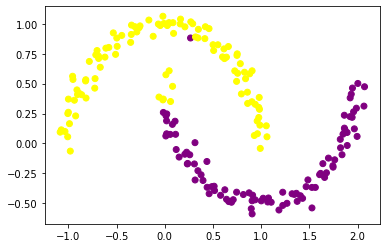

In [17]:
# specify colors for scatter plot based on certain conditions
def clustering_plot(X, sign):
    color = ["purple" if x < -0.0015 else "yellow" for x in sign]
    plt.scatter(X[:, 0], X[:, 1], c = color)
clustering_plot(X, z_.x)

Wow, that's pretty close. There's only a small portion of the purple crescent which gets confused to be yellow. So ``minimize()`` does a great job here, but it's still flawed. There's further works that need to be done. Also, notice that we use -0.0015 instead of 0 to differentiate between the negative and positive values due to some numerical errors; we suspect this to be a problem from ``minimize()`` as well since there's a clear distinction between them when we define `z` based on the label of each data point.

## The Eivenvectors of Laplacian Matrix

Explicitly optimizing the orthogonal objective is  *way* too slow to be practical. If spectral clustering required that we do this each time, no one would use it. 

The reason that spectral clustering actually matters, and indeed the reason that spectral clustering is called *spectral* clustering, is that we can actually solve the problem from Part E using eigenvalues and eigenvectors of matrices. 

Recall that what we would like to do is minimize the function 

$$ R_\mathbf{A}(\mathbf{z})\equiv \frac{\mathbf{z}^T (\mathbf{D} - \mathbf{A})\mathbf{z}}{\mathbf{z}^T\mathbf{D}\mathbf{z}} $$

with respect to $\mathbf{z}$, subject to the condition $\mathbf{z}^T\mathbf{D}\mathbb{1} = 0$. 

The Rayleigh-Ritz Theorem states that the minimizing $\mathbf{z}$ must be the solution with smallest eigenvalue of the generalized eigenvalue problem 

$$ (\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{D}\mathbf{z}\;, \quad \mathbf{z}^T\mathbf{D}\mathbb{1} = 0$$

which is equivalent to the standard eigenvalue problem 

$$ \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A}) \mathbf{z} = \lambda \mathbf{z}\;, \quad \mathbf{z}^T\mathbb{1} = 0\;.$$

Why is this helpful? Well, $\mathbb{1}$ is actually the eigenvector with smallest eigenvalue of the matrix $\mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$. 

> So, the vector $\mathbf{z}$ that we want must be the eigenvector with  the *second*-smallest eigenvalue. 

Construct the matrix $\mathbf{L} = \mathbf{D}^{-1}(\mathbf{D} - \mathbf{A})$, which is often called the (normalized) *Laplacian* matrix of the similarity matrix $\mathbf{A}$. 

Let's now find this eigenvector and call it ``z_eig``.

In [18]:
# define the Laplacian matrix
L = np.linalg.inv(D)@(D-A)
# compute the eigenvalues and eigenvectors of L
eigval, eigvec = np.linalg.eig(L)
# set the smallest eigenvalue to be something greater than itself
eigval[np.where(eigval == eigval.min())[0][0]] = 1
# the second smallest eigenvalue now is the min so we can set z_eig accordingly
z_eig = eigvec[:, np.where(eigval == eigval.min())[0][0]]

We plot the data again to see how ``z_eig`` affects the clustering.

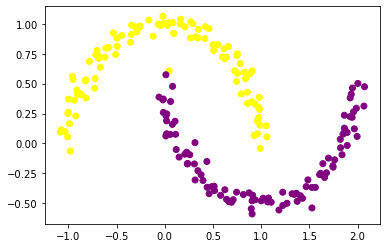

In [19]:
clustering_plot(X, z_eig)

Impressive! Spectral clustering works almost perfectly as there is only one point that is purple point mistook to be yellow at the top left.

## Spectral Clustering
Now, let's define a function that sums up everything that we have done from the beginning up to this part. This function can be considered as a compact version of the spectral clustering algorithm.

In [20]:
def spectral_clustering(X, epsilon):
    """
    FUNCTION
    --------
    Perform spectral clustering and generate an array of labels
    which specifies what group a data point in X belongs to
    
    PARAMETERS
    ----------
    X      : input data (numpy array)
    epsilon: distance threshold to build a similarity matrix (float)
    
    RETURN
    ------
    an array of binary labels of each data point in X
    """
    # construct the similarity matrix
    A = pairwise_distances(X)
    A[A >= epsilon] = 0
    A[(A != 0) & (A < epsilon)] = 1
    
    # construct the Laplacian matrix and
    # compute the eigenvector correspond to the second-smallest 
    # eigenvalue of the Laplacian
    D = np.zeros((n, n))
    np.fill_diagonal(D, np.sum(A, axis = 1))
    eigval, eigvec = np.linalg.eig(np.linalg.inv(D)@(D-A))
    
    # eigval is placed in an increasing order so the second column is what we want
    # and the negative values correspond to 1 and positive values correspond to 0
    return (eigvec[:, 1] < 0) * 1

As usual, we need to test to see whether the function works as we expect it to.

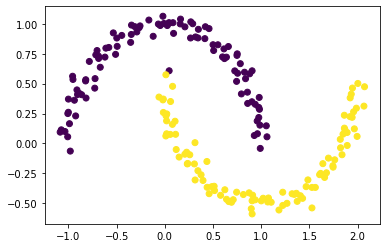

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=spectral_clustering(X, epsilon))

Woo-hoo! We just successfully implemented and packaged a concrete version of spectral clustering algorithm.

So what's next? At this point, we will run a few more experiments using our function but with generating different data sets using `make_moons`. In details, we want to investigate how does the ``noise`` affect the accuracy of our algorithm.

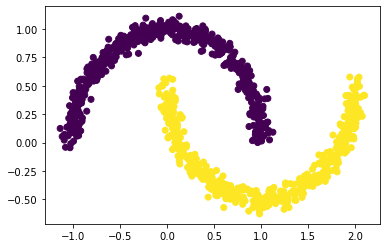

In [30]:
# let's increase to 1000 data points as our function is quite fast now
n = 1000
# low noise level
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.05, random_state=None)
plt.scatter(X[:, 0], X[:, 1], c=spectral_clustering(X, epsilon=0.4))

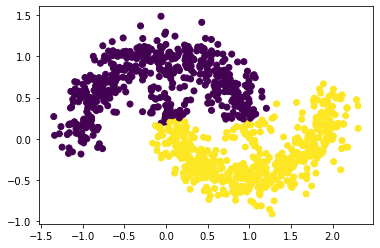

In [31]:
# + .1 to the noise
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.15, random_state=None)
plt.scatter(X[:, 0], X[:, 1], c=spectral_clustering(X, epsilon=0.4))

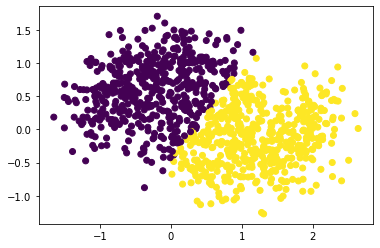

In [36]:
# + .15 to the noise
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.3, random_state=None)
plt.scatter(X[:, 0], X[:, 1], c=spectral_clustering(X, epsilon=0.4))

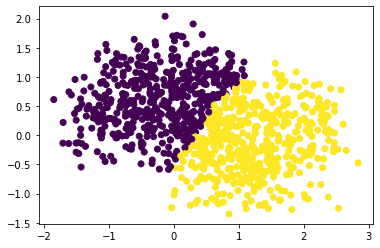

In [71]:
# + .1 to the noise
X, y = datasets.make_moons(n_samples=n, shuffle=True, noise=0.4, random_state=None)
plt.scatter(X[:, 0], X[:, 1], c=spectral_clustering(X, epsilon=0.4))

After this point, if we keep increasing the noise, we will keep encounter the error where the matrix generated is singular which ,mathematically speaking, would prevent us from computing the inverse in one of the steps shown above. An interesting pattern can be observed here is that the higher the noise is the more the shape diverges from a crescent. At ``noise = 0.3``, we can see that the plot no longer looks like a crescent but rather a chunk of data with a not very clear pattern. That's why it makes sense that our algorithm decides to split this shape into half with a straight line.

To further test the function, why we don't try with some more data sets; in this case, a bull-eye! 

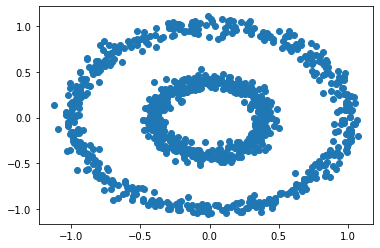

In [74]:
n = 1000
X, y = datasets.make_circles(n_samples=n, shuffle=True, noise=0.05, random_state=None, factor = 0.4)
plt.scatter(X[:,0], X[:,1])

There are two concentric circles. As before k-means will not do well here at all. 

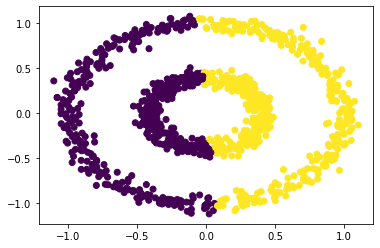

In [73]:
km = KMeans(n_clusters = 2)
km.fit(X)
plt.scatter(X[:,0], X[:,1], c = km.predict(X))

Let's see how our function performs.

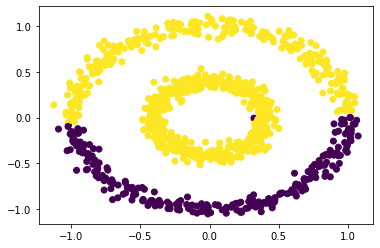

In [79]:
plt.scatter(X[:,0], X[:,1], c=spectral_clustering(X, epsilon=0.2))

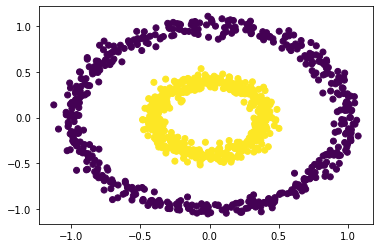

In [80]:
plt.scatter(X[:,0], X[:,1], c=spectral_clustering(X, epsilon=0.4))

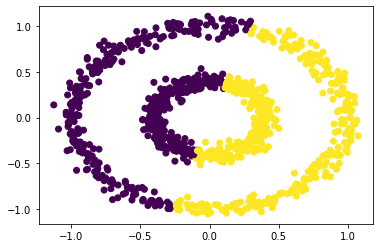

In [81]:
plt.scatter(X[:,0], X[:,1], c=spectral_clustering(X, epsilon=0.6))

It appears that ``epsilon = 0.4`` is the optimal value that supports the function to correctly predict the two regions.